In [4]:
%matplotlib inline


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, \
    cross_val_score, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

import warnings
warnings.filterwarnings("ignore")

## [Задача](https://www.kaggle.com/rodolfomendes/abalone-dataset#abalone.csv): предсказание возраста морских ушек с помощью деревьев решений

- Рассмотрите задачу и как классификацию, и как регрессию;
- Попробуйте разные методы регуляризации: `max_depth`, `min_samples_split`, `min_samples_leaf`, `max_features`, `max_leaf_nodes`, `min_impurity_decrease`, `min_impurity_split`, `ccp_alpha`;
- Для обучения классификатора попробуйте опции `class_weight='balanced'` и `class_weight=None`;
- Измерьте `R2` на тестовой выборке;
- Ответьте на вопросы:
  - Имеет ли смысл экспериментировать с кодированием категориального признака `'Sex'`?
  - Имеет ли смысл подвергать преобразованиям числовые признаки?

###Анализ данных

In [ ]:
abalone_data = pd.read_csv('/content/abalone.csv')
abalone_data.head()

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


In [ ]:
abalone_data.shape

(4177, 9)

In [ ]:
abalone_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 9 columns):
Sex               4177 non-null object
Length            4177 non-null float64
Diameter          4177 non-null float64
Height            4177 non-null float64
Whole weight      4177 non-null float64
Shucked weight    4177 non-null float64
Viscera weight    4177 non-null float64
Shell weight      4177 non-null float64
Rings             4177 non-null int64
dtypes: float64(7), int64(1), object(1)
memory usage: 293.8+ KB


In [ ]:
abalone_data.describe()

,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
count,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000
mean,0.523992,0.407881,0.139516,0.828742,0.359367,0.180594,0.238831,9.933684
std,0.120093,0.099240,0.041827,0.490389,0.221963,0.109614,0.139203,3.224169
min,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,1.000000
25%,0.450000,0.350000,0.115000,0.441500,0.186000,0.093500,0.130000,8.000000
50%,0.545000,0.425000,0.140000,0.799500,0.336000,0.171000,0.234000,9.000000
75%,0.615000,0.480000,0.165000,1.153000,0.502000,0.253000,0.329000,11.000000
max,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000,29.000000


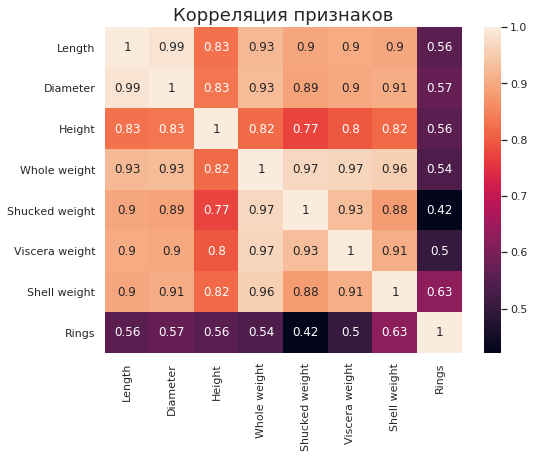

In [ ]:
correlation = abalone_data.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation, annot=True)
plt.title('Корреляция признаков', size=18);

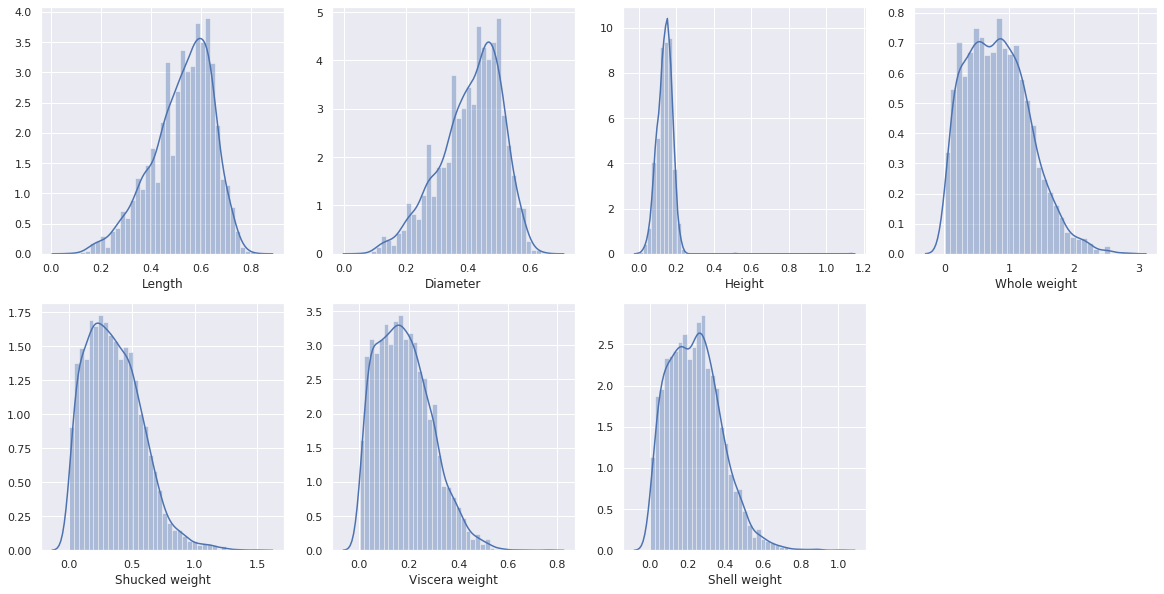

In [ ]:
plt.figure(figsize=(20, 10))

plt.subplot(2, 4, 1), sns.distplot(abalone_data['Length'])
plt.subplot(2, 4, 2), sns.distplot(abalone_data['Diameter'])
plt.subplot(2, 4, 3), sns.distplot(abalone_data['Height'])
plt.subplot(2, 4, 4), sns.distplot(abalone_data['Whole weight'])
plt.subplot(2, 4, 5), sns.distplot(abalone_data['Shucked weight'])
plt.subplot(2, 4, 6), sns.distplot(abalone_data['Viscera weight'])
plt.subplot(2, 4, 7), sns.distplot(abalone_data['Shell weight']);

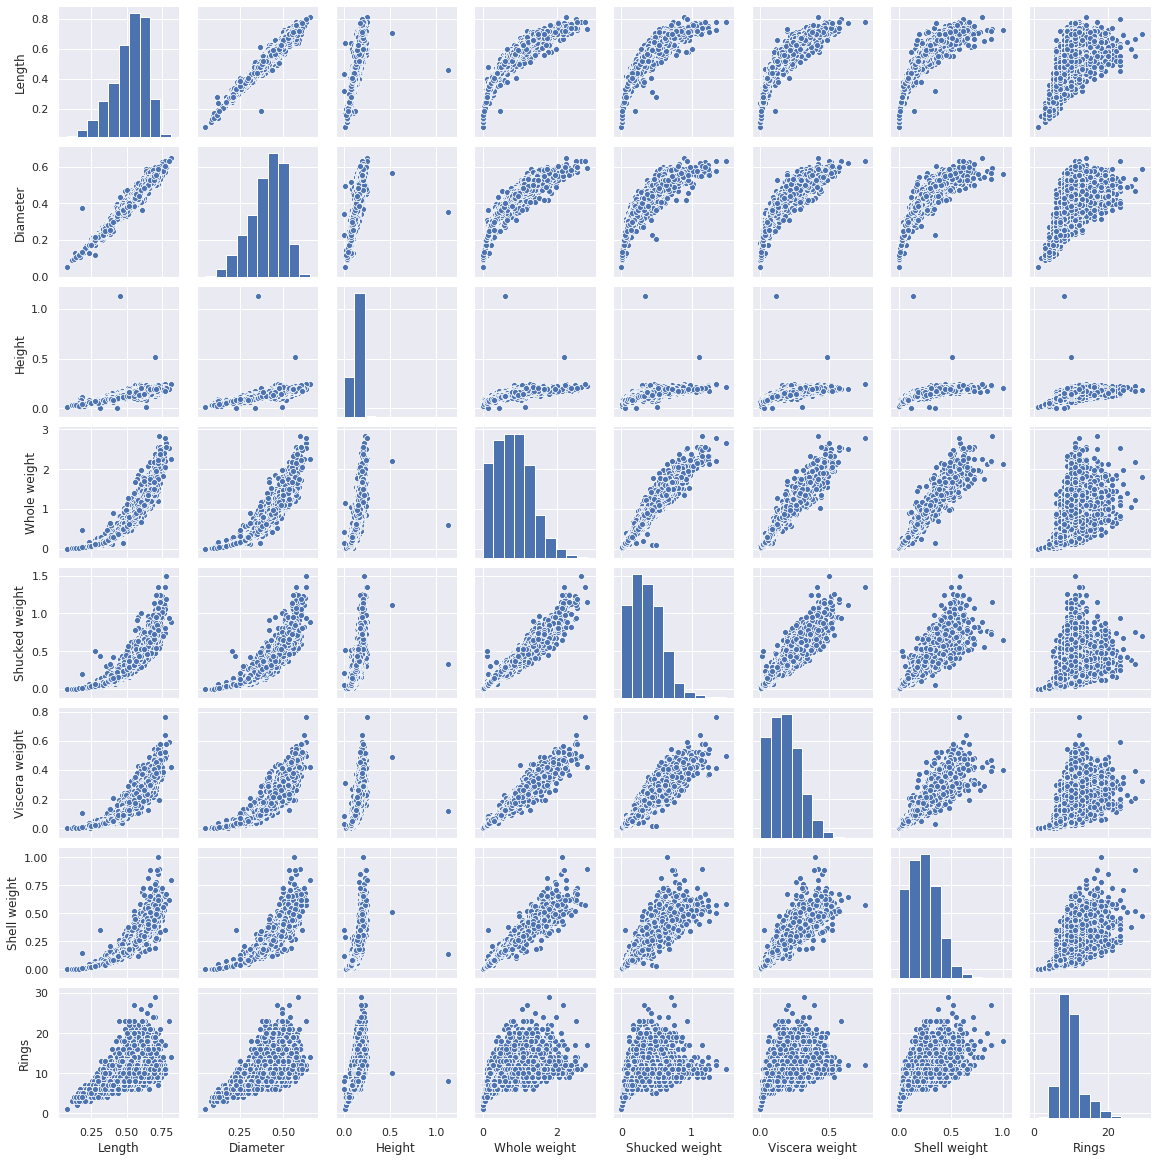

In [ ]:
sns.pairplot(abalone_data, height=2);

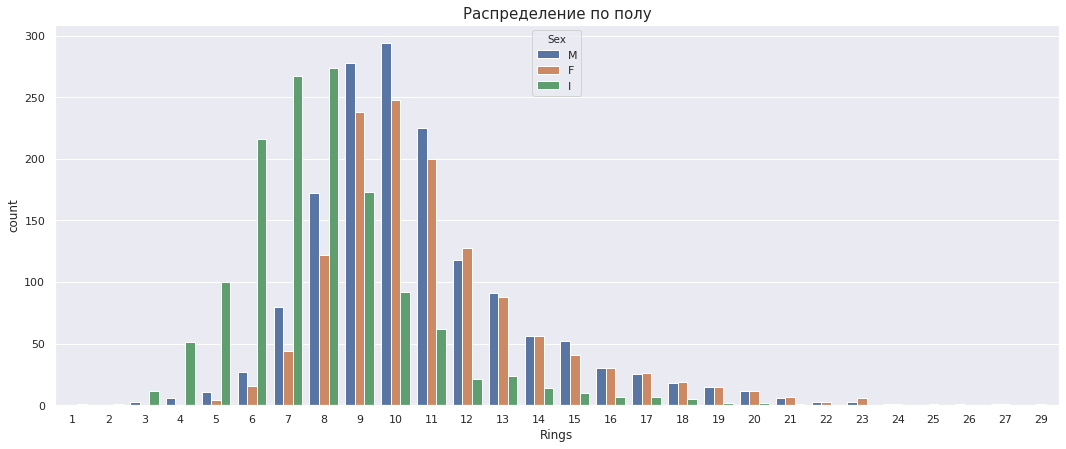

In [ ]:
plt.figure(figsize=(18, 7))
sns.countplot(abalone_data['Rings'], hue=abalone_data['Sex'])
plt.title(label='Распределение по полу', fontdict={'fontsize': 15});

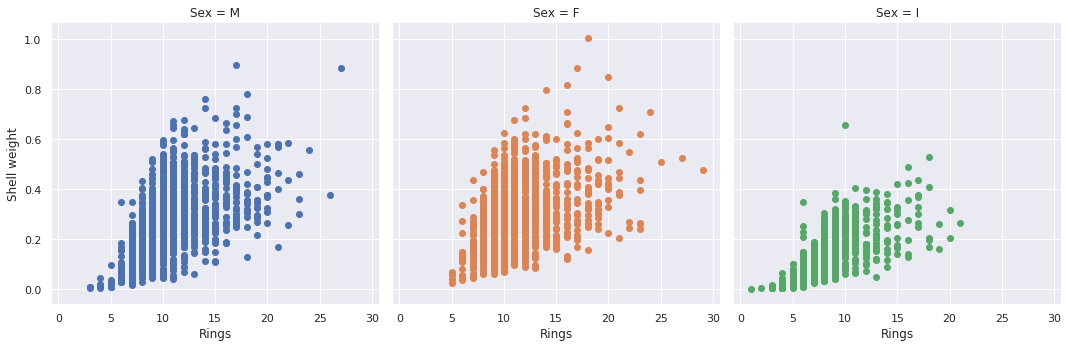

In [ ]:
# возьмем признак с самой высокой корреляцией

p = sns.FacetGrid(abalone_data, col='Sex', hue='Sex', height=5)
p = p.map(plt.scatter, 'Rings', 'Shell weight')

In [ ]:
# закодируем признак 'Sex'с помощью get_dummies

abalone_data_dumm = pd.get_dummies(abalone_data, columns=['Sex'])
abalone_data_dumm.head()

,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings,Sex_F,Sex_I,Sex_M
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15,0,0,1
1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7,0,0,1
2,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9,1,0,0
3,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10,0,0,1
4,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7,0,1,0


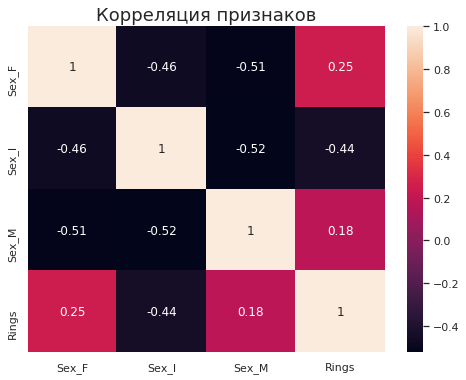

In [ ]:
correlation = abalone_data_dumm[['Sex_F', 'Sex_I', 'Sex_M', 'Rings']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation, annot=True)
plt.title('Корреляция признаков', size=18);

###О датасете:
- отсутствуют значения nan
- один признак с типом данных object
- один признак с типом int
- 7 признаков с типом float
- числовые признаки довольно сильно скоррелированы между собой и оказывают примерно одинаковое влияние на целевую переменную
- отсутствует видимая разница в данных для мужского/женского пола, если это не Infanf

###Обучение

In [6]:
train_url = 'https://raw.githubusercontent.com/Katalinach/ML-Datasets/master/abalone_train.csv?token=ANTWLAFPEZS3CBPB2MVPVS27G35GM'
test_url = 'https://raw.githubusercontent.com/Katalinach/ML-Datasets/master/abalone_test.csv?token=ANTWLADSWVT5YN2F4XUHIVS7G35HO'
train_df = pd.read_csv(train_url)
test_df = pd.read_csv(test_url)

In [7]:
X_train = train_df.drop(['Rings'], axis=1)
y_train = train_df['Rings']
X_test = test_df.drop(['Rings'], axis=1)
y_test = test_df['Rings']

In [8]:
# закодируем признак 'Sex'с помощью get_dummies, оставив только столбец для Infant

X_train = pd.get_dummies(X_train, columns=['Sex'])
X_test = pd.get_dummies(X_test, columns=['Sex'])
X_train = X_train.drop(['Sex_F', 'Sex_M'], axis=1)
X_test = X_test.drop(['Sex_F', 'Sex_M'], axis=1)

In [ ]:
clf_cls = DecisionTreeClassifier()

params = [{'max_depth': np.arange(1, 20)},
          {'min_samples_split': np.arange(2, 20)},
          {'min_samples_leaf': np.arange(1, 20)},
          {'max_features': np.arange(1, 11)},
          {'max_leaf_nodes': np.arange(1, 20)},
          {'min_impurity_decrease': np.arange(0, 1, 0.01)},
          {'min_impurity_split': np.arange(0, 1, 0.01)},
          {'ccp_alpha': np.arange(0, 1, 0.01)}
          ]

for param in params:
  gs = GridSearchCV(clf_cls, param_grid=param, scoring='r2', cv=5, n_jobs=-1)
  gs.fit(X_train, y_train)
  y_pred = gs.predict(X_test)
  r2 = r2_score(y_test, y_pred)
  print('best_parameter:', gs.best_params_, '//', 'r2_score:', round((r2), 2))

best_parameter: {'max_depth': 6} // r2_score: 0.36
best_parameter: {'min_samples_split': 19} // r2_score: 0.3
best_parameter: {'min_samples_leaf': 17} // r2_score: 0.39
best_parameter: {'max_features': 8} // r2_score: 0.14
best_parameter: {'max_leaf_nodes': 19} // r2_score: 0.29
best_parameter: {'min_impurity_decrease': 0.0} // r2_score: 0.14
best_parameter: {'min_impurity_split': 0.77} // r2_score: 0.3
best_parameter: {'ccp_alpha': 0.0} // r2_score: 0.19


In [ ]:
# возьмем 2 признака с лучшими результатами для подбора class_weight

from sklearn.metrics import r2_score

class_weights = ['balanced', None]

for class_weight in class_weights:
  clf_cls = DecisionTreeClassifier(max_depth=6, min_samples_leaf=17, class_weight=class_weight)
  clf_cls.fit(X_train, y_train)
  y_pred = clf_cls.predict(X_test)
  r2 = r2_score(y_test, y_pred)
  print(class_weight, 'r2_score:', round((r2), 2))

balanced r2_score: -5.34
None r2_score: 0.39


Отрицательное значение говорит о безрезультативности модели, ее предсказания хуже, чем оценки на основе простого среднего.

In [ ]:
clf_rgs = DecisionTreeRegressor()

params = [{'max_depth': np.arange(1, 20)},
          {'min_samples_split': np.arange(2, 20)},
          {'min_samples_leaf': np.arange(1, 20)},
          {'max_features': np.arange(1, 11)},
          {'max_leaf_nodes': np.arange(1, 20)},
          {'min_impurity_decrease': np.arange(0, 1, 0.01)},
          {'min_impurity_split': np.arange(0, 1, 0.01)},
          {'ccp_alpha': np.arange(0, 1, 0.01)}
          ]

for param in params:
  gs = GridSearchCV(clf_rgs, param_grid=param, scoring='r2', cv=5, n_jobs=-1)
  gs.fit(X_train, y_train)
  y_pred = gs.predict(X_test)
  r2 = r2_score(y_test, y_pred)
  print('best_parameter:', gs.best_params_, '//', 'r2_score:', round((r2), 2))

best_parameter: {'max_depth': 5} // r2_score: 0.43
best_parameter: {'min_samples_split': 19} // r2_score: 0.31
best_parameter: {'min_samples_leaf': 19} // r2_score: 0.47
best_parameter: {'max_features': 4} // r2_score: 0.07
best_parameter: {'max_leaf_nodes': 18} // r2_score: 0.43
best_parameter: {'min_impurity_decrease': 0.05} // r2_score: 0.44
best_parameter: {'min_impurity_split': 0.84} // r2_score: 0.12
best_parameter: {'ccp_alpha': 0.07} // r2_score: 0.43


In [ ]:
# проверим результат с нормализацией

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_train = scaler.fit_transform(X_train)
scaled_test = scaler.transform(X_test)

In [ ]:
clf_cls = DecisionTreeClassifier(max_depth=6, min_samples_leaf=17, class_weight=None)
clf_cls.fit(scaled_train, y_train)
y_pred = clf_cls.predict(scaled_test)
r2 = r2_score(y_test, y_pred)
print('r2_score:', round((r2), 2))

r2_score: 0.39


**1) Имеет ли смысл экспериментировать с кодированием категориального признака 'Sex'?**

Имеет смысл для разделения на infant/не infant, таким образом можно получить более высокие значения для моделей (были проверены разные варианты).

**2) Имеет ли смысл подвергать преобразованиям числовые признаки?**

Нет, т.к. у признаков нет большого разброса значений и на практике нормализация для таких признаков не улучшает результат.

**3) Как регрессия модель показывает результаты лучше, чем как классификация.**

